This notebook is for collecting Reddit comments for the purpose of topic modeling and topic transitions. I will be attacking the problem in the style of logs written by the character Watney in *The Martian*. That is, straitforward and stepping the stones of problems as they come. A method of problem solving that tries to build something first, before optimizing. And, without optimizing the path of progress as well. With that, let's first build some tools to extract Reddit comments.

In [1]:
import praw

In [2]:
r = praw.Reddit('comment LDA')
sub = r.get_subreddit('science')
posts = list(sub.get_hot(limit=1000))
sub.get_top()

I want to start simple, and do a tf-idf frequency sort on post titles. First, I'll need to tokenize the titles and store them as documents. I'll do a relatively crude tokenizer using NLTK that accounts for punctuation and removes it.

In [3]:
from nltk.tokenize import RegexpTokenizer

In [4]:
tokenizer = RegexpTokenizer("[\w']+")
documents = [tokenizer.tokenize(p.title.lower().replace("'s", '')) for p in posts]
print(documents[0])

['gravity', 'kills', 'schrödinger', 'cat']


In [5]:
from nltk.stem import WordNetLemmatizer

In [6]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('is'))
print(lemmatizer.lemmatize('is', pos='v'))

/usr/local/lib/python3.4/site-packages/nltk/corpus/reader/wordnet.py:1039: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/henrywallace/nltk_data/corpora/wordnet/lexnames'>
  for i, line in enumerate(self.open('lexnames')):
/usr/local/lib/python3.4/site-packages/nltk/corpus/reader/wordnet.py:1101: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/henrywallace/nltk_data/corpora/wordnet/index.adv'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/usr/local/lib/python3.4/site-packages/nltk/corpus/reader/wordnet.py:1101: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/henrywallace/nltk_data/corpora/wordnet/index.verb'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/usr/local/lib/python3.4/site-packages/nltk/corpus/reader/wordnet.py:1101: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/henrywallace/nltk_data/corpora/wordnet/index.adj'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/usr/loca

is
be


Notice that we have to give the correct POS tag for the lemmatizer to work properly. This means that we have to POS tag each of the post titles as well. So, let's do that.

In [7]:
from nltk import pos_tag
from nltk.corpus.reader import wordnet

In [8]:
def wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
lemma_docs = [[lemmatizer.lemmatize(w, pos=wordnet_pos(pos)) for w, pos in pos_tag(d)] for d in documents]

In [10]:
lemma_docs[0]

['gravity', 'kill', 'schrödinger', 'cat']

Now, before I do tf-idf. Let's see what the results of the most common words are.

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
%matplotlib inline
from itertools import chain

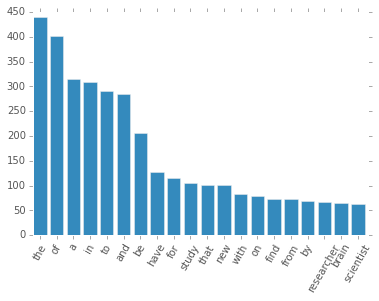

In [12]:
word_counts = Counter(chain.from_iterable(lemma_docs))
x, y = zip(*word_counts.most_common(20))
ind = np.arange(len(x))
plt.bar(ind, y)
plt.xticks(ind + 0.4, x, rotation=60)
plt.show()

Just as we'd expect there's a lot of conjunctions in there. So let's try to filter those out using tf-idf. 

In [13]:
doc_word_counts = [dict(Counter(d)) for d in lemma_docs]
word_doc_counts = {w: sum(w in d for d in lemma_docs) for w in word_counts.keys()}
doc_tfidf = [{w: (1 + np.log(dwc[w]))*np.log(1 + len(documents)/word_doc_counts[w]) \
              for w in dwc.keys()} for dwc in doc_word_counts]

Now, we'll just look up what non-stopwords have the highest tf-idf score sum. I didn't want to do averages as it might count infrequent high-scorers above those with many instance, but only slightly smaller scores.

In [14]:
from nltk.corpus import stopwords

In [15]:
stop = set(stopwords.words('english'))
term_avg_tfidf = {w: np.sum([dt.get(w, 0) for dt in doc_tfidf]) for w in word_counts.keys() if w not in stop}
sorted(term_avg_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]

/usr/local/lib/python3.4/site-packages/nltk/corpus/reader/wordlist.py:25: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/henrywallace/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


[('study', 223.07455041540874),
 ('new', 218.64100372839729),
 ('find', 179.19028957720224),
 ('researcher', 169.57105915125953),
 ('brain', 163.59455128591117),
 ('scientist', 163.02082383766125),
 ('may', 145.55405157834934),
 ('cell', 134.71853489557046),
 ('research', 129.86527263272581),
 ('year', 122.56172270058377)]

In [16]:
from wordcloud import WordCloud

/usr/local/lib/python3.4/site-packages/wordcloud/wordcloud.py:26: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.4/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  'stopwords')).read().split('\n')])


In [47]:
from itertools import repeat
from scipy.misc import imread

In [39]:
terms = sorted(term_avg_tfidf.items(), key=lambda x: x[1], reverse=True)[:100]
big_string = ' '.join(' '.join(repeat(w, int(c))) for w, c in terms)

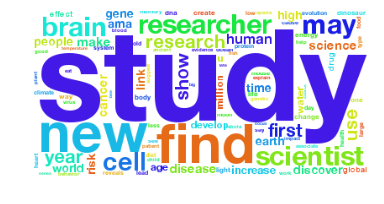

In [48]:
cloud = WordCloud(background_color='white', font_path='/System/Library/Fonts/HelveticaNeue.dfont').generate(big_string)
plt.imshow(cloud)
plt.axis('off')
plt.show()